In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [30]:
inflationEuro = pd.read_csv('Raw Data/ECB_inflation.csv')
inflationEuro.rename(columns={'HICP - Overall index (ICP.M.U2.N.000000.4.ANR)': 'inflation'}, inplace=True)
inflationEuro['inflation'] = inflationEuro['inflation'].astype(float)
inflationEuro['DATE'] = pd.to_datetime(inflationEuro['DATE'])
inflationEuro['YEAR_MONTH'] = inflationEuro['DATE'].dt.to_period('M')
inflationEuro = inflationEuro[
    inflationEuro['YEAR_MONTH'].between('2003-03', '2021-01')
]
inflationEuro.set_index('YEAR_MONTH', inplace=True)
inflationEuro.index = inflationEuro.index.to_timestamp()
inflationEuro.drop(['TIME PERIOD', 'DATE'], axis=1, inplace=True)
inflationEuro['inflation'] = inflationEuro['inflation']/100
inflationEuro.head()

,inflation
YEAR_MONTH,
2003-03-01,0.024
2003-04-01,0.021
2003-05-01,0.018
2003-06-01,0.020
2003-07-01,0.019


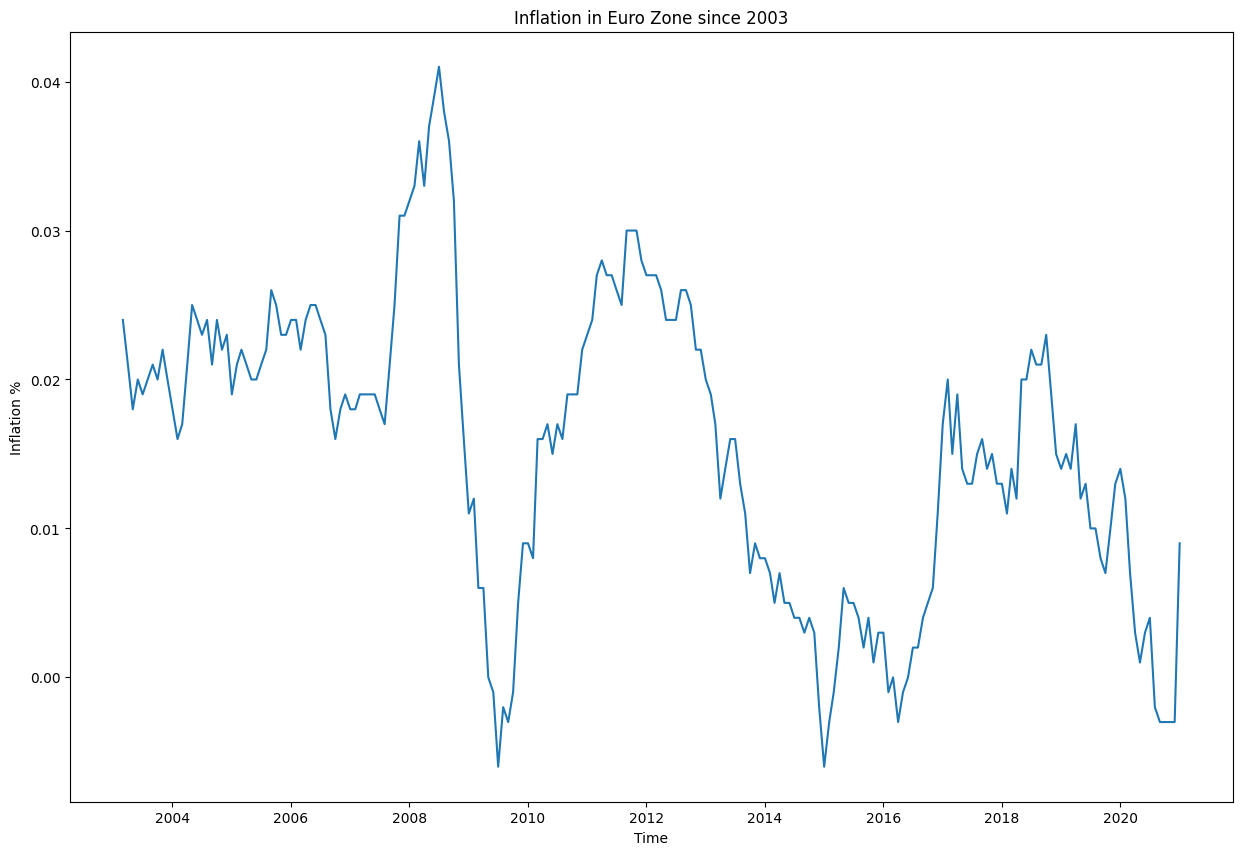

In [31]:
fig = plt.figure(figsize=(15,10))
plt.plot(inflationEuro.index, inflationEuro.inflation)
plt.xlabel('Time')
plt.ylabel('Inflation %')
plt.title('Inflation in Euro Zone since 2003')
plt.show()

In [32]:
inflationEuro.to_csv('Processed Data/inflation_euro_processed.csv', index=True)

Modelling

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

class Vasicek:
    """
    Vasicek (Ornstein–Uhlenbeck) model for interest rates using the exact discretization
    """
    def __init__(self):
        self.calibrated = False
        self.a = None       
        self.mu = None      
        self.sigma = None   

    def calibrate_ols(self, r, dt):
        """
        Calibrate the Vasicek model parameters using Ordinary Least Squares (OLS).
        """
        r = np.asarray(r).flatten()
        X = r[:-1]
        Y = r[1:]
        X_const = sm.add_constant(X)
        model = sm.OLS(Y, X_const)
        results = model.fit()
        
        alpha = results.params[0]
        beta = results.params[1]
        
        a_est = -np.log(beta) / dt
        mu_est = alpha / (1 - beta)
        
        mse = results.mse_resid
        sigma_est = np.sqrt(mse * (2 * a_est / (1 - np.exp(-2 * a_est * dt))))
        
        self.a = a_est
        self.mu = mu_est
        self.sigma = sigma_est
        self.calibrated = True
        
        return a_est, mu_est, sigma_est, results

    def calibrate_mle(self, r, dt):
        """
        Calibrate the Vasicek model parameters using Maximum Likelihood Estimation (MLE).
        """
        r = np.asarray(r).flatten()
        n = len(r)
        S0 = np.sum(r[:-1]) / (n - 1)
        S1 = np.sum(r[1:]) / (n - 1)
        S00 = np.sum(r[:-1]**2) / (n - 1)
        S01 = np.sum(r[:-1] * r[1:]) / (n - 1)
        
        b_MLE = (S1 * S00 - S0 * S01) / (S0 * S1 - S0**2 - S01 + S00)
        a_est = 1 / dt * np.log((S0 - b_MLE) / (S1 - b_MLE))
        
        temp = 0
        for i in range(n - 1):
            m_i = r[i] * np.exp(-a_est * dt) + b_MLE * (1 - np.exp(-a_est * dt))
            temp += (r[i + 1] - m_i) ** 2
        sigma_est = np.sqrt((2 * a_est / (1 - np.exp(-2 * a_est * dt))) * (temp / (n - 1)))
        
        self.a = a_est
        self.mu = b_MLE
        self.sigma = sigma_est
        self.calibrated = True
        
        return a_est, b_MLE, sigma_est

    def simulate_exact(self, r0, T, num_steps, num_paths, a=None, mu=None, sigma=None):
        """
        Simulate the Vasicek model using the exact discretization.
        """
        dt = T / num_steps
        
        if a is None or mu is None or sigma is None:
            if self.calibrated:
                a = self.a
                mu = self.mu
                sigma = self.sigma
            else:
                raise ValueError("Parameters not provided and the model is not calibrated.")
                
        rates = np.zeros((num_steps + 1, num_paths))
        rates[0, :] = r0
        
        exp_term = np.exp(-a * dt)
        drift = mu * (1 - exp_term)
        vol_factor = sigma * np.sqrt((1 - np.exp(-2 * a * dt)) / (2 * a))
        
        for t in range(1, num_steps + 1):
            dW = np.random.normal(0, 1, num_paths)
            rates[t, :] = drift + exp_term * rates[t - 1, :] + vol_factor * dW
            
        return rates
    
    def simulate_deterministic(self, r0, T, num_steps, num_paths, a=None, mu=None):
        """
        Simulate the deterministic (backtest) part by omitting the stochastic noise.
        """
        dt = T / num_steps
        if a is None or mu is None:
            if self.calibrated:
                a, mu = self.a, self.mu
            else:
                raise ValueError("Parameters not provided and model not calibrated.")
        rates = np.zeros((num_steps+1, num_paths))
        rates[0, :] = r0
        exp_term = np.exp(-a * dt)
        drift = mu * (1 - exp_term)
        for t in range(1, num_steps+1):
            rates[t, :] = drift + exp_term * rates[t-1, :]
        return rates

    def plot_paths(self, time_axis, simulated_paths, average, upper_bound, lower_bound, deterministic=None, calibration_data=None):
        plt.figure(figsize=(10, 6))
        plt.title('Vasicek Model - Simulated Inflation Paths')
        plt.xlabel('Time (years)')
        plt.ylabel('Inflation')
        num_paths = simulated_paths.shape[1]
        for i in range(num_paths):
            plt.plot(time_axis, simulated_paths[:, i], lw=0.8, alpha=0.3, color='blue')
        plt.plot(time_axis, average, color='black', linestyle='--', lw=3, label='Average (Stochastic)')
        plt.plot(time_axis, upper_bound, color='grey', linestyle='--', lw=2, label='Upper Bound (2σ)')
        plt.plot(time_axis, lower_bound, color='grey', linestyle='--', lw=2, label='Lower Bound (2σ)')
        if deterministic is not None:
            plt.plot(time_axis, np.mean(deterministic, axis=1), color='green', linestyle='-', lw=3, label='Deterministic')
        if calibration_data is not None:
            calibration_data = np.asarray(calibration_data)
            if len(calibration_data) != len(time_axis):
                obs_time = np.linspace(time_axis[0], time_axis[-1], len(calibration_data))
                calibration_data = np.interp(time_axis, obs_time, calibration_data)
            plt.plot(time_axis, calibration_data, color='red', linestyle='-', lw=2, label='Real Data')
        plt.legend()
        plt.show()

In [34]:
inflationEuro_data = inflationEuro.inflation.values

In [35]:
dt = 1/12  
vasicek = Vasicek()
a_est, mu_est, sigma_est, ols_results = vasicek.calibrate_ols(inflationEuro_data, dt)

In [36]:
print(f'Speed of mean reversion: {np.round(a_est, 2)} %')
print(f'Long term mean: {np.round(mu_est, 2)} %')
print(f'Sigma: {np.round(sigma_est, 2)} %')
print(f'R-Squared Adjusted: {np.round(ols_results.rsquared_adj * 100, 2)} %')

Speed of mean reversion: 0.48 %
Long term mean: 0.01 %
Sigma: 0.01 %
R-Squared Adjusted: 92.4 %


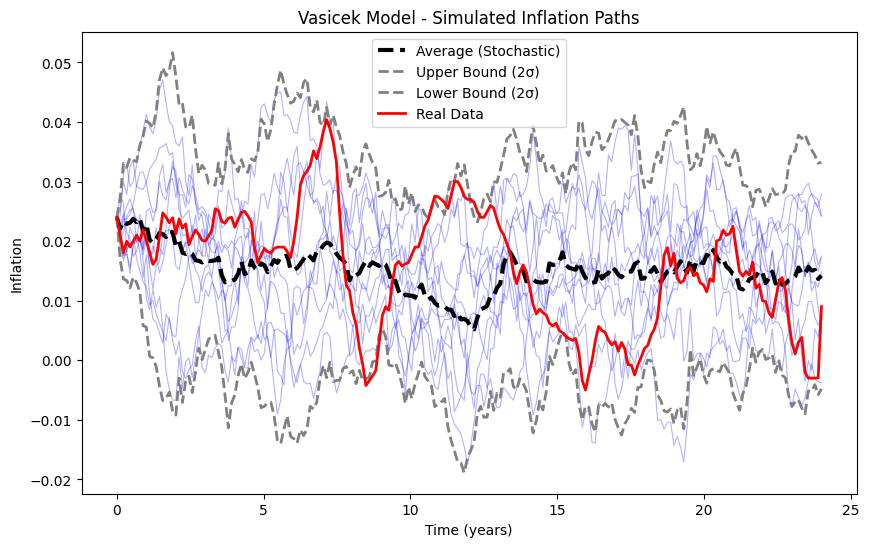

In [37]:
r0 = inflationEuro.iloc[0]
T = 24
num_steps = len(inflationEuro_data-1) 
num_paths = 10
simulated = vasicek.simulate_exact(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated, axis=1)
sigma_sim = np.std(simulated, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

vasicek.plot_paths(time_axis=time_axis, simulated_paths=simulated, average=avg_rates, upper_bound=upper_bound, lower_bound=lower_bound, deterministic=None, calibration_data=inflationEuro_data)

Normality of residuals test

In [38]:
# Shapiro Test of Normality

shapiro_test = stats.shapiro(ols_results.resid)
shapiro_test

ShapiroResult(statistic=0.9780861983989816, pvalue=0.0020458842713318493)

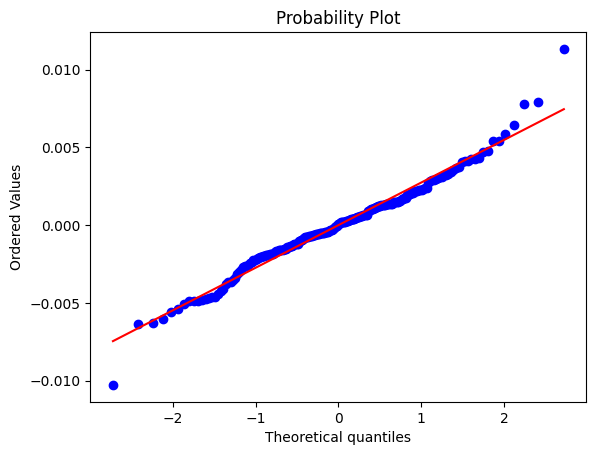

In [39]:
## QQ-Plot against normal distribution

stats.probplot(ols_results.resid, dist='norm', plot=plt)
plt.show()

In [40]:
inflationEuro = inflationEuro.iloc[1:]
inflationEuro['residuals'] = ols_results.resid
inflationEuro.to_csv("Processed Data/ols_model_residuals_inflation.csv", index=True)

Backtesting with only the deterministic value

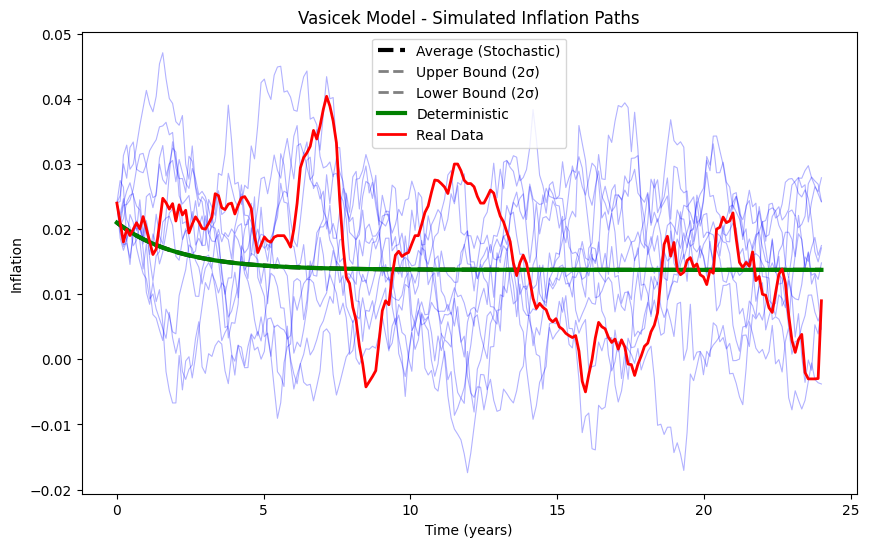

In [41]:
dt = 1/12 
vasicek = Vasicek()
a_est, mu_est, sigma_est, ols_results = vasicek.calibrate_ols(inflationEuro_data, dt)

r0 = inflationEuro.iloc[0]['inflation']
T = 24
num_steps = len(inflationEuro_data-1) 
num_paths = 1
simulated_deterministic = vasicek.simulate_deterministic(r0, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps+1)
avg_rates = np.mean(simulated_deterministic, axis=1)
sigma_sim = np.std(simulated_deterministic, axis=1)
upper_bound = avg_rates + 2 * sigma_sim
lower_bound = avg_rates - 2 * sigma_sim

vasicek.plot_paths(time_axis=time_axis, simulated_paths=simulated, average=avg_rates, upper_bound=upper_bound, lower_bound=lower_bound, deterministic=simulated_deterministic, calibration_data=inflationEuro_data)